In [1]:
import shap
import pandas as pd
import scipy as sp
import numpy as np
from irf.ensemble import wrf
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from treeinterpreter.feature_importance import feature_importance as FI
from treeinterpreter.feature_importance import MDA

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Compare different methods in terms of feature pruning performance

### load data

In [2]:
X_train = np.loadtxt('../intermediate/02_enhancer/X_train.csv', delimiter=',')
y_train = np.loadtxt('../intermediate/02_enhancer/y_train.csv', delimiter=',')
X_test = np.loadtxt('../intermediate/02_enhancer/X_test.csv', delimiter=',')
y_test = np.loadtxt('../intermediate/02_enhancer/y_test.csv', delimiter=',')
n, m = X_train.shape
names = np.arange(m)

### Train RF

In [3]:
rf = wrf(n_estimators=100, max_features=8)
for i in range(4):
    try:
        rf.fit(X_train, y_train, feature_weight=rf.feature_importances_)
    except:
        rf.fit(X_train, y_train, feature_weight=None)
#rf = rfc(n_estimators=100, max_features=8, max_depth=5)
#rf.fit(X_train, y_train)
gini_imp = rf.feature_importances_

- accuracy

In [4]:
print('accuracy of RF is {0:.3f}'.format(accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))))

accuracy of RF is 0.926


- Plot feature importance

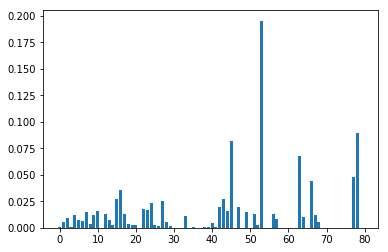

In [5]:
plt.bar(x = np.arange(X_train.shape[1]), height = gini_imp)
plt.show()

### prune features based on their importance measures

- classic gini importance

     - plot the gini importance

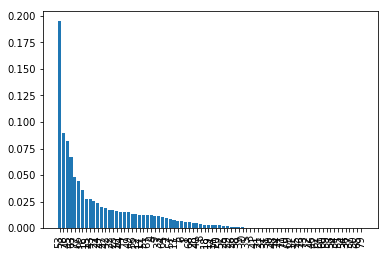

In [6]:
ix = np.argsort(gini_imp * -1)
plt.bar(x = list(range(m)), height = gini_imp[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- debiased gini importance

In [7]:
y_train_one_hot = OneHotEncoder().fit_transform(y_train[:, np.newaxis]).todense()

In [8]:
debiased_fi_mean, debiased_fi_std = FI(rf, X_train, y_train_one_hot, type='oob', normalized=False)

/home/ubuntu/github/treeinterpreter/treeinterpreter/treeinterpreter.py:72: UserWarning: the instance is not recognized. Try to proceed with classifier but could fail.
  warnings.warn('the instance is not recognized. Try to proceed with classifier but could fail.')


    - plot debiased gini importance

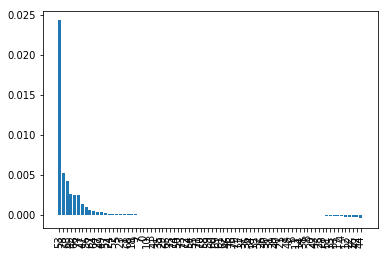

In [9]:
debiased_imp = debiased_fi_mean
ix = np.argsort(debiased_imp * -1)
plt.bar(x = list(range(m)), height = debiased_imp[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- OOB MDA

In [10]:
MDA_oob_imp, MDA_oob_std = MDA(rf, X_train, y_train[:, np.newaxis], type='oob', n_trials=1)

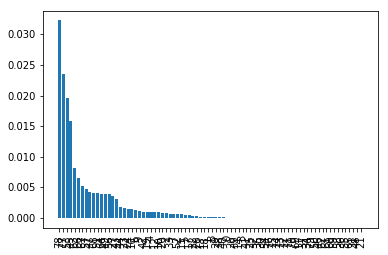

In [11]:
ix = np.argsort(MDA_oob_imp * -1)
plt.bar(x = list(range(X_train.shape[1])), height = MDA_oob_imp[ix])
plt.xticks(list(range(X_train.shape[1])), np.array(names)[ix], rotation='vertical')
plt.show()

- MDA

/home/ubuntu/github/treeinterpreter/treeinterpreter/feature_importance.py:23: RuntimeWarning: invalid value encountered in double_scalars
  permute_std = (permute_std - permute_score ** 2) ** .5 / n_trials ** .5


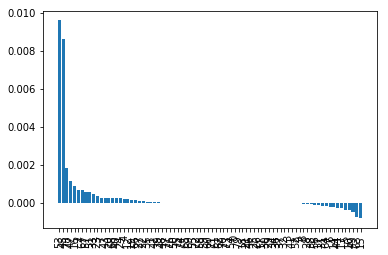

In [80]:
MDA_imp, _ = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=10)
#MDA_imp[MDA_imp < 0] = 0
ix = np.argsort(MDA_imp * -1)
plt.bar(x = list(range(m)), height = MDA_imp[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- tree SHAP

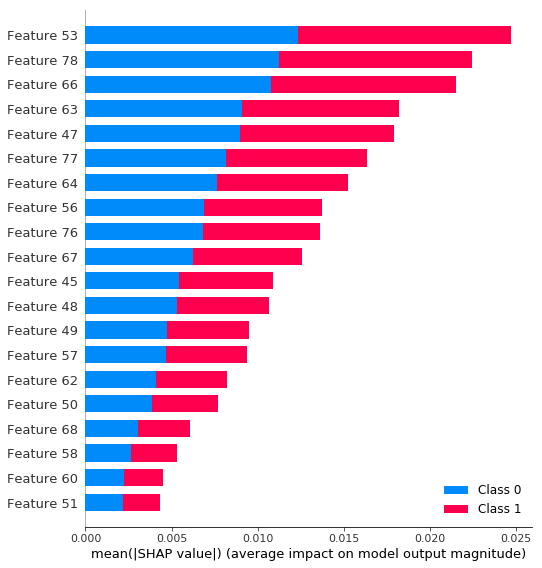

In [55]:
explainer = shap.TreeExplainer(rf)
samples = np.random.choice(range(X_train.shape[0]), 100)
shap_values = explainer.shap_values(X_train[samples, :])
shap.summary_plot(shap_values, X_train[samples, :], plot_type="bar")

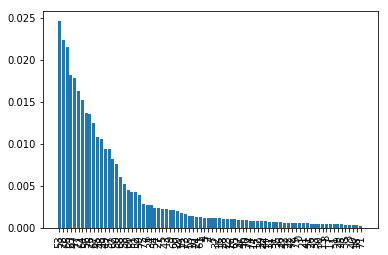

In [81]:
shap_imp = np.mean(abs(shap_values[0]), 0) + np.mean(abs(shap_values[1]), 0)
ix = np.argsort(shap_imp * -1)
plt.bar(x = list(range(m)), height = shap_imp[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

### Comparison

In [82]:
def rank_correlation(x, y):
    return sp.corrcoef(sp.stats.rankdata(x), sp.stats.rankdata(y))[0,1]

- In terms of correlation with MDA

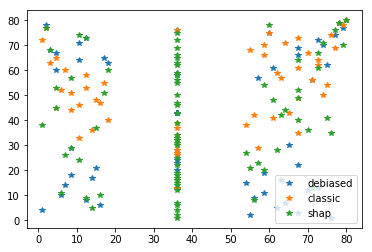

In [83]:
ix = np.argsort(MDA_imp * -1)
plt.plot(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(debiased_imp[ix]), '*')
plt.plot(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(gini_imp[ix]), '*')
plt.plot(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(shap_imp[ix]), '*')
plt.legend(['debiased', 'classic', 'shap'])
plt.show()

In [87]:
MDA_imp[MDA_imp < 0] = 0
debiased_imp[debiased_imp < 0] = 0
rank_correlation(MDA_imp, debiased_imp)

0.15059242886394014

In [88]:
rank_correlation(MDA_imp, gini_imp)

0.292484838701519

In [89]:
rank_correlation(MDA_imp, shap_imp)

0.16116713408208852

    - how accuracy decreases if we permute the feature from the least important to the most important

In [313]:
import multiprocessing as mp
def plot_accuracy_drop(rf, X_test, y_test, feature_imp):
    imp_ranking = sp.stats.rankdata(feature_imp + np.random.normal(0, 1e-4, feature_imp.shape)) - 1
    a = mp.Pool(mp.cpu_count() // 2)
    tmp = np.array([a.apply(MDA_consecutive, args = (rf, X_test, y_test, imp_ranking, i)) for i in range(8)])
    scores = np.mean(tmp, 0)
    std = np.std(tmp, 0) / tmp.shape[0] ** .5
    a.close()
    #scores = MDA_consecutive(rf, X_test, y_test, imp_ranking, n_trials=4)
    plt.errorbar(x=list(range(len(scores))), y=scores, yerr=std)
    plt.xticks(list(range(len(scores))), np.array(names), rotation='vertical')

In [314]:
def MDA_consecutive(rf, 
                    X_test, 
                    y_test, 
                    mask,
                    seed = None,
                    n_trials = 1):
    
    n_features = len(mask)
    np.random.seed(seed)
    n_groups = len(np.unique(mask))
    assert n_groups == max(mask) + 1
    scores = np.zeros((n_groups,))
    best_score = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
    tmp = X_test.copy()
    for _ in range(n_trials):
        for i in range(n_groups):
            tmp[:, mask == i] = np.random.permutation(tmp[:, mask == i])
            score = accuracy_score(y_true=y_test, y_pred=rf.predict(tmp))
            scores[i] += score - best_score
    return scores / n_trials

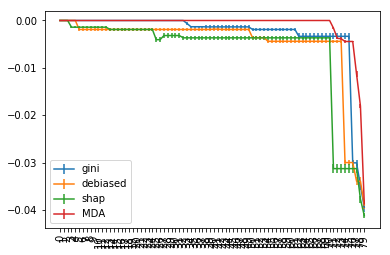

In [315]:
plot_accuracy_drop(rf, X_test, y_test, gini_imp)
plot_accuracy_drop(rf, X_test, y_test, debiased_imp)
plot_accuracy_drop(rf, X_test, y_test, shap_imp)
plot_accuracy_drop(rf, X_test, y_test, MDA_imp)
plt.legend(['gini', 'debiased', 'shap', 'MDA'])

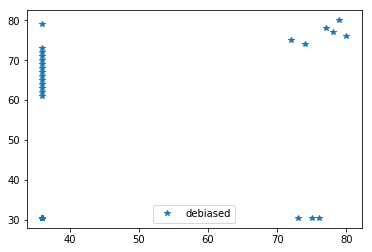

In [288]:
debiased_imp[debiased_imp < 0] = 0
ix = np.argsort(MDA_imp * -1)
plt.plot(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(debiased_imp[ix]), '*')
#plt.plot(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(gini_imp[ix]), '*')
#plt.plot(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(shap_imp[ix]), '*')
plt.legend(['debiased', 'classic', 'shap'])
plt.show()

In [281]:
sp.stats.rankdata(gini_imp), sp.stats.rankdata(MDA_imp)

(array([34. , 48. , 54. , 31. , 53. , 42. , 49. , 60. , 52. , 57. , 65. ,
        14.5, 62. , 51. , 38. , 73. , 74. , 56. , 41. , 46. , 35. , 29. ,
        61. , 66. , 71. , 36. , 37. , 72. , 45. , 33. , 14.5, 14.5, 14.5,
        55. , 14.5, 14.5, 14.5, 14.5, 30. , 39. , 44. , 14.5, 69. , 70. ,
        63. , 77. , 14.5, 68. , 14.5, 43. , 32. , 67. , 40. , 80. , 14.5,
        14.5, 58. , 59. , 14.5, 14.5, 14.5, 14.5, 14.5, 78. , 64. , 14.5,
        76. , 50. , 47. , 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5, 14.5,
        75. , 79. , 14.5]),
 array([75., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
        36., 76., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 73.,
        36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
        36., 36., 36., 36., 36., 36., 80., 36., 74., 36., 36., 36., 36.,
        36., 79., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36.,
        36., 78., 36., 36., 36., 36., 36., 36., 36., 36., 36., 36., 72.,
        77., 36.

In [275]:
sp.corrcoef(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(gini_imp[ix]))

array([[1.        , 0.35554093],
       [0.35554093, 1.        ]])

In [278]:
debiased_imp[debiased_imp < 0] = 0
sp.corrcoef(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(debiased_imp[ix]))

array([[1.        , 0.43189414],
       [0.43189414, 1.        ]])

In [277]:
sp.corrcoef(sp.stats.rankdata(MDA_imp[ix]), sp.stats.rankdata(shap_imp[ix]))

array([[1.        , 0.24965654],
       [0.24965654, 1.        ]])